In [1]:
# Uncomment and execute to mount google drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd /content/gdrive/MyDrive/DKRZ\ Task/Task

/content/gdrive/MyDrive/DKRZ Task/Task


In [3]:
import os
from config import config
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, dataloader
from torchvision import transforms
from model import CNN, Net, MLP, CNNLSTM
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy import stats as ss
from dataLoader import WindDataset, WindDatasetSequence
from imgaug import augmenters as iaa
import collections
import random
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt 
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Task 1

Download the data from https://nextcloud.dkrz.de/s/QJKHqnRD7PLSK8R (500 MB). The data is in
NetCDF4 format, which can be accessed with the Python library xarray. Extract the image data of
good quality and the corresponding wind speed labels.

In [4]:
# Load the NetCDF4
with xr.open_dataset("./dataset/cygnss_four_channels.nc") as ds:
    pass

## Dataset description 

#### - X: brcs is a n-2d array used to create Images.
#### - Y: windspeed is used as labels
#### - quality is used to select good quality images in the dataset (0: bad, 1: good quality)

In [5]:
ds

<xarray.Dataset>
Dimensions:            (delay: 17, doppler: 11, sd: 785053)
Dimensions without coordinates: delay, doppler, sd
Data variables:
    spacecraft_id      (sd) int16 ...
    spacecraft_num     (sd) int8 ...
    delay_resolution   (sd) float32 ...
    ddm_timestamp_utc  (sd) datetime64[ns] ...
    zenith_code_phase  (sd) float32 ...
    brcs               (sd, delay, doppler) float32 ...
    windspeed          (sd) float64 ...
    quality            (sd) int32 ...
Attributes: (12/57)
    Conventions:                     CF-1.6, ACDD-1.3, ISO-8601
    standard_name_vocabulary:        CF Standard Name Table v30
    project:                         CYGNSS
    featureType:                     trajectory
    summary:                         CYGNSS is a NASA Earth Venture mission, ...
    program:                         CYGNSS
    ...                              ...
    geospatial_lon_max:              360.000E
    time_coverage_resolution:        P0DT0H0M1S
    time_coverage_start:             2018-01-01T00:00:00.999261410Z
    time_coverage_end:               2018-01-01T23:59:59.999261582Z
    time_coverage_duration:          P1DT0H0M0S
    NCO:                             4.4.4

## Generate Good & Bad Quality Images

In [6]:
# good and bad image frequencies in the dataset
quality = np.array(ds['quality'])
collections.Counter(quality)

Counter({0: 582338, 1: 202715})

In [7]:
# Choose some random good quality images 
random.seed(11)
good_quality_indexes = np.where(quality == 1)[0]
random_good_quality_indexes = [random.choice(good_quality_indexes) for _ in range(4)]

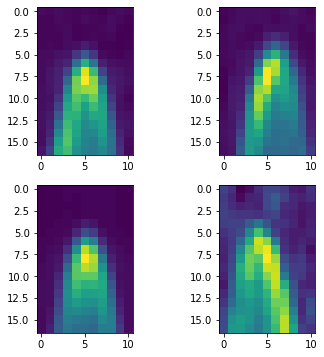

In [8]:
# Display those randomly choosen Images
imgs = [ds['brcs'][i]  for i in random_good_quality_indexes]
_, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()
for img, ax in zip(imgs, axs): 
    img  = np.array(img)         
    ax.imshow(img)    
plt.show()

In [9]:
# Choose some random bad quality images 
bad_quality_indexes = np.where(quality == 0)[0]
random_bad_quality_indexes = [random.choice(bad_quality_indexes) for _ in range(4)]

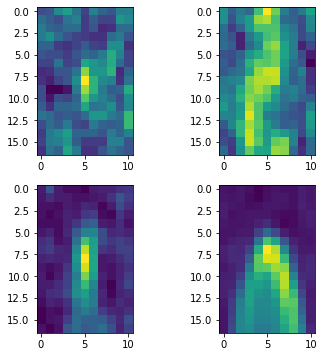

In [10]:
# Display some bad quality images
imgs = [ds['brcs'][i]  for i in random_bad_quality_indexes]
_, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()
for img, ax in zip(imgs, axs): 
    img  = np.array(img)        
    ax.imshow(img)    
plt.show()

In [11]:
# Split the dataset into training, val and test : 80, 10, 10

# total dataset Length (Only good Images)
total_good_dataset_len = len(good_quality_indexes)
training_set = good_quality_indexes[:int(0.8 * total_good_dataset_len)]
val_set = good_quality_indexes[int(0.8 * total_good_dataset_len) : int(0.9 * total_good_dataset_len)]
test_set =  good_quality_indexes[int(0.9 * total_good_dataset_len):]

## Histogram plot showing frequncy of Windspeed(Y)

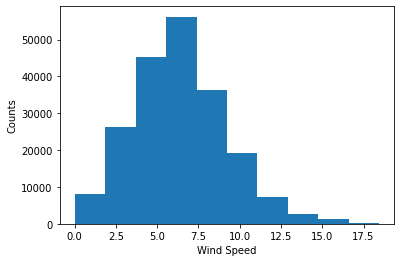

In [12]:
plt.hist(ds['windspeed'].values[good_quality_indexes], bins = 10)
plt.xlabel('Wind Speed')
plt.ylabel('Counts')
plt.show()

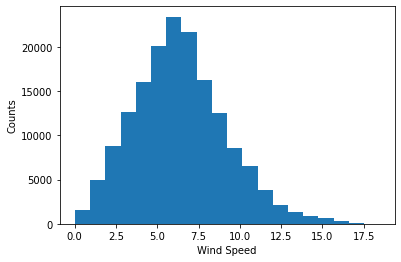

In [13]:
# Train Data Distribution
plt.hist(ds['windspeed'].values[good_quality_indexes][0: int(0.8 * total_good_dataset_len)], bins = 20)
plt.xlabel('Wind Speed')
plt.ylabel('Counts')
plt.show()

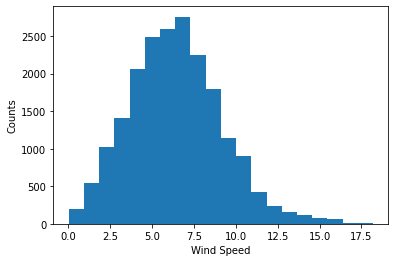

In [14]:
# Validation data distribution
plt.hist(ds['windspeed'].values[good_quality_indexes][int(0.8 * total_good_dataset_len): int(0.9 * total_good_dataset_len)], bins = 20)
plt.xlabel('Wind Speed')
plt.ylabel('Counts')
plt.show()

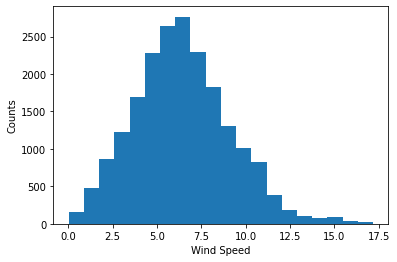

In [15]:
# Test  data distribution
plt.hist(ds['windspeed'].values[good_quality_indexes][int(0.9 * total_good_dataset_len):], bins = 20)
plt.xlabel('Wind Speed')
plt.ylabel('Counts')
plt.show()

In [16]:
# Choose a computing device based on availability 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
# Convert to numpy array
imageData = ds['brcs'].values
windData = ds['windspeed'].values

In [18]:
# standardize all the good quality Images
imageData = ss.zscore(imageData[good_quality_indexes], axis=1)
trainingWindData  = windData[training_set]
windData = windData[good_quality_indexes]

#Task 2

Use a machine learning framework of your choice to implement an artificial neural network that predicts wind speed from CyGNSS measurements. Motivate your choice of network, and discuss your
results.

In [19]:
# Get class weights for WeightedRandom Sampler, weight of class = 1/frequency of that class
tempWindData = np.around(trainingWindData)
tempWindData = tempWindData.astype(int)
freq_dict = dict(collections.Counter(tempWindData))
class_count = np.array([freq_dict.get(i,0) for i in range(len(freq_dict))])
weight=1/class_count
samples_weight = np.array([weight[t] for t in tempWindData])
samples_weight=torch.from_numpy(samples_weight)

if config['randomSampler']:
  trainingRandomsampler = WeightedRandomSampler(samples_weight, len(samples_weight))
else:
  trainingRandomsampler = None

In [20]:
# Check if there is some NAN data, set it to 0

if np.any(np.isnan(imageData)):
  imageData[np.isnan(imageData)] = 0

np.any(np.isnan(imageData))


False

In [21]:
# Define Augmentation to be applied on Images to increase the dataset
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips   
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),          
], random_order=True) # apply augmenters in random order

In [22]:
# Hyperparams
BATCH_SIZE = config['batch_size']
LR = config['learning_rate'] 
transform =  None
if config['cnn'] or config['pre_train_cnn'] or config['CNNLSTM']:
  transform = transforms.Compose([
      seq.augment_image,    
  ])   
transform = None

In [23]:
# Generate DataLoaders
  
# Use different Dataset class for CNN-LSTM
if config['CNNLSTM']:
  # Dataset
  trainDataSet = WindDatasetSequence(training_set, dataset = (imageData, windData), transform=transform)
  valDataSet = WindDatasetSequence(val_set, dataset = (imageData, windData), transform=transform)
  testDataSet = WindDatasetSequence(test_set, dataset = (imageData, windData), transform=transform)

  #DataLoaders
  train_loader = dataloader.DataLoader(dataset=trainDataSet, batch_size=BATCH_SIZE, shuffle=False, drop_last = True, num_workers=2, pin_memory=True)
  validation_loader = dataloader.DataLoader(dataset=valDataSet, batch_size=BATCH_SIZE, shuffle=False, drop_last = True, num_workers=2, pin_memory=True)
  test_loader = dataloader.DataLoader(dataset=testDataSet, batch_size=BATCH_SIZE, shuffle=False, drop_last = True, num_workers=2, pin_memory=True)

else:
  # Dataset
  trainDataSet = WindDataset(training_set, dataset = (imageData, windData), transform=transform)
  valDataSet = WindDataset(val_set, dataset = (imageData, windData))
  testDataSet = WindDataset(test_set, dataset = (imageData, windData))

  # DataLoaders
  # Apply RandomWeghtedSampler to only train loader, if True, and set shuffle to false
  if config['randomSampler']:
    train_loader = dataloader.DataLoader(dataset=trainDataSet, batch_size=BATCH_SIZE, shuffle=False, drop_last = True, sampler=trainingRandomsampler, pin_memory=True, num_workers=2)
  else:
    train_loader = dataloader.DataLoader(dataset=trainDataSet, batch_size=BATCH_SIZE, shuffle=True, drop_last = True, sampler=None, pin_memory=True, num_workers=2)

  validation_loader = dataloader.DataLoader(dataset=valDataSet, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)
  test_loader = dataloader.DataLoader(dataset=testDataSet, batch_size=BATCH_SIZE, shuffle=False, drop_last = True)

In [24]:
# Choose a MLP, CNN, a pretrain-CNN or CNN-LSTM Network as per the config settings in config.py file

if config['mlp']:
  model = MLP().to(device)
elif config['cnn']:
  model = Net().to(device)
elif config['pre_train_cnn']:
  model = CNN(num_classes=1)
  # Change the Input Channel of the image to 1
  model.resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  # Freeze layers before last fully connected layer of pre-train network
  for name, param in model.resnet50.named_parameters():
      if "fc.weight" in name or "fc.bias" in name:
          param.requires_grad = True    
      else:
          param.requires_grad = False 
  model.to(device)  
elif config['CNNLSTM']:
  model = CNNLSTM().to(device)


# net architecture
print(model) 

# Define Optimizer, Learning rate Scheduler and Loss
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9)   # optimize all cnn parameters
scheduler = None

# Learning Rate Scheduler
if config['scheduler']:
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.01)

# Loss
criterion = nn.MSELoss()

MLP(
  (fc1): Linear(in_features=187, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [25]:
device

'cpu'

In [26]:
# Check Accuracy, by rounding off the Target and Prediction values to Nearest Integer
def check_accuracy(loader, model):
    acc_type = None
    if loader == train_loader:
      acc_type = "train"      
    elif loader == validation_loader:
      acc_type = "val"
    else:
      acc_type = "test"

    num_correct = 0
    num_samples = 0
    
    with torch.no_grad():
        model.eval()
        for x, y in loader:
          if config['cnn'] or config['pre_train_cnn'] :
            x = torch.unsqueeze(x, 1)  
          elif config['CNNLSTM']:      
            x = torch.unsqueeze(x, 2)
          elif config['mlp']:
            x = x.view(BATCH_SIZE, -1)
          
          if len(y.size()) == 1:
            y = torch.unsqueeze(y, 1)    

            x = x.to(device=device)
            y = y.to(device=device)            
            predictions = model(x)            
            predictions = torch.round(predictions)
            y = torch.round(y)
                        
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)            
    print(f" {acc_type} accuracy {float(num_correct)/float(num_samples)*100 :.2f} % with {num_correct} / {num_samples} ")            
    model.train()

### Training the Network

In [27]:
n_epochs = config['num_epochs']
valid_loss_min = np.Inf
val_loss = []
train_loss = []
total_step = len(train_loader)

for epoch in range(1, n_epochs+1):
    running_loss = 0.0    
    correct = 0
    total = 0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data, target) in enumerate(train_loader):          
        # push the data on GPU, if available
        data, target = data.to(device), target.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Convert the data according to the choice of network selected in config.py file        
        if config['cnn'] or config['pre_train_cnn'] :
          data = torch.unsqueeze(data, 1)  
        elif config['CNNLSTM']:          
          data = torch.unsqueeze(data, 2)
        elif config['mlp']:
          data = data.view(BATCH_SIZE, -1)
        
        if len(target.size()) == 1:
          target = torch.unsqueeze(target, 1)  

        # forward + backward + optimize             
        outputs = model(data.float())
        target = target.float()                
        # Calculate Loss        
        loss = criterion(outputs, target)           
        loss.backward()
        # Update Parameters
        optimizer.step()
        # print validation statistics
        running_loss += loss.item()       
        if (batch_idx) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))  
    
    # Save Training Loss for each epoch Avg Batch loss: (Total_epoch_loss/ Num of batches)
    train_loss.append(running_loss/total_step)

    # Start Validation
    
    # validation loss
    batch_loss = 0        
    with torch.no_grad():
        model.eval()
        for batch_idx, (data_v, target_v) in enumerate(validation_loader):
            # push the data on CPU/GPU
            data_v, target_v = data_v.to(device), target_v.to(device)

            # Convert the data according to the choice of network selected in config.py file                             
            if config['cnn'] or config['pre_train_cnn'] :
              data_v = torch.unsqueeze(data_v, 1)      
            elif config['CNNLSTM']:   
               data_v = torch.unsqueeze(data_v, 2)   
            elif config['mlp']:
              data_v = data_v.view(BATCH_SIZE, -1)           

            target_v = torch.unsqueeze(target_v, 1)  
            
            # forward 
            outputs_v = model(data_v.float())

            # Calculate loss
            loss_v = criterion(outputs_v, target_v)
            
            # Extract current scalar loss value from tensor and add it to total batch loss
            batch_loss += loss_v.item()   

        # Save Validation Loss for each epoch Avg Batch loss: (Total_epoch_loss/ Num of batches)
        val_loss.append(batch_loss/len(validation_loader))

        print(f'validation loss: {np.mean(val_loss):.4f} \n')
                
        # Saving the current weights; if val batch_loss is less than previous_val_minimum batch loss 
        network_learned = batch_loss < valid_loss_min
        if network_learned:
            valid_loss_min = batch_loss
            # Importing Best Saved Network
            if config['cnn'] :
              torch.save(model.state_dict(), './saved_models_weights/model_regression_cnn.pt')
            elif config['pre_train_cnn']:
              torch.save(model.state_dict(), './saved_models_weights/model_regression_pre_train_cnn.pt')  
            elif config['CNNLSTM']:   
              torch.save(model.state_dict(), './saved_models_weights/model_regression_CNNLSTM.pt')  
            elif config['mlp']:
              torch.save(model.state_dict(), './saved_models_weights/model_regression_mlp.pt')  
             
            print('Detected network improvement, saving current model')
    
    # If scheduler is turned on, then decrease the learning rate
    if config['scheduler']:
      scheduler.step()    
    # Switch the model from Eval mode to train mode, for training
    model.train()

Epoch 1

Epoch [1/200], Step [0/633], Loss: 46.7057
Epoch [1/200], Step [100/633], Loss: 6.0393
Epoch [1/200], Step [200/633], Loss: 7.1629
Epoch [1/200], Step [300/633], Loss: 6.2141
Epoch [1/200], Step [400/633], Loss: 6.2303
Epoch [1/200], Step [500/633], Loss: 6.7803
Epoch [1/200], Step [600/633], Loss: 6.2883
validation loss: 6.9108 

Detected network improvement, saving current model
Epoch 2

Epoch [2/200], Step [0/633], Loss: 7.5744
Epoch [2/200], Step [100/633], Loss: 7.7759
Epoch [2/200], Step [200/633], Loss: 7.4294
Epoch [2/200], Step [300/633], Loss: 7.6457
Epoch [2/200], Step [400/633], Loss: 5.9730
Epoch [2/200], Step [500/633], Loss: 7.4578
Epoch [2/200], Step [600/633], Loss: 6.7007
validation loss: 6.7503 

Detected network improvement, saving current model
Epoch 3

Epoch [3/200], Step [0/633], Loss: 5.5888
Epoch [3/200], Step [100/633], Loss: 6.3800
Epoch [3/200], Step [200/633], Loss: 5.6855
Epoch [3/200], Step [300/633], Loss: 6.5665
Epoch [3/200], Step [400/633], L

### Training vs Validation Loss 

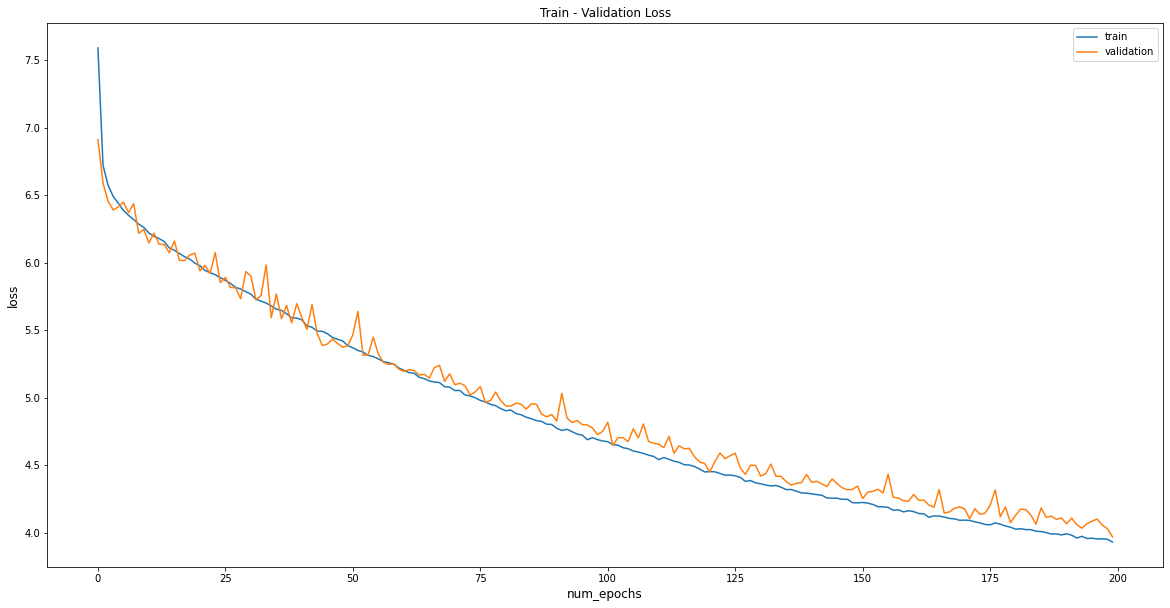

In [28]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

In [29]:
# Importing Best Saved Network
if config['cnn'] :
  model.load_state_dict(torch.load('./saved_models_weights/model_regression_cnn.pt'))
elif config['pre_train_cnn']:
  model.load_state_dict(torch.load('./saved_models_weights/model_regression_pre_train_cnn.pt'))
elif config['CNNLSTM']:   
  model.load_state_dict(torch.load('./saved_models_weights/model_regression_CNNLSTM.pt'))
elif config['mlp']:
  model.load_state_dict(torch.load('./saved_models_weights/model_regression_mlp.pt'))

In [30]:
# Defining dataloader again, Setting the Transform to None for CNN part

if config['CNNLSTM']:  
  trainDataSet = WindDatasetSequence(training_set, dataset = (imageData, windData), transform=transform)
  train_loader = dataloader.DataLoader(dataset=trainDataSet, batch_size=BATCH_SIZE, shuffle=False, drop_last = True, num_workers=2, pin_memory=True)
else:  
  trainDataSet = WindDataset(training_set, dataset = (imageData, windData), transform=None)
  train_loader = dataloader.DataLoader(dataset=trainDataSet, batch_size=BATCH_SIZE, shuffle=False, drop_last = True, sampler=trainingRandomsampler)



### Results

In [31]:
# Calculate Loss for Train, Validation and Test dataset 

def mse(loader):
  loss = []
  targets = [] 
  pred = []
  batch_loss = 0
  test_targets_ = []
  test_pred_ = []
  with torch.no_grad():
    model.eval()
    for data_t, target_t in (loader):
        # push the data on GPU, if available
        data_t, target_t = data_t.to(device), target_t.to(device)# on GPU              
        # Convert the data according to the choice of network selected in config.py file                             
        if config['cnn'] or config['pre_train_cnn'] :
          data_t = torch.unsqueeze(data_t, 1)      
        elif config['CNNLSTM']:   
          data_t = torch.unsqueeze(data_t, 2)   
        elif config['mlp']:
          data_t = data_t.view(BATCH_SIZE, -1)              
        
        target_t = torch.unsqueeze(target_t, 1)  
        # forward
        outputs_t = model(data_t.float())        
        
        targets.append(target_t)
        pred.append(outputs_t)
        # Calculate Loss and update batch loss
        loss_t = criterion(outputs_t, target_t)
        batch_loss += loss_t.item()
    
    loss = batch_loss/len(loader)    
    return loss, targets, pred

train_mse,_, _ = mse(train_loader)
val_mse, _, _  = mse(validation_loader)
test_mse, targets, pred = mse(test_loader)

print(f' \n \n train loss: {train_mse} \n \n  val loss: {val_mse} \n \n test loss: {test_mse}')

 
 
 train loss: 3.8065505706853413 
 
  val loss: 3.9694353646632385 
 
 test loss: 3.9694353646632385


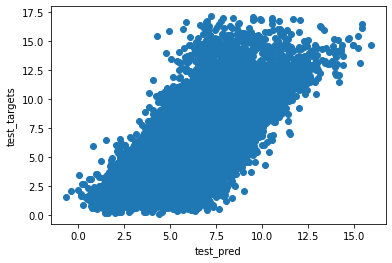

In [32]:
# Create Scatter plot for TrainingData and prediction Data
test_targets_ = targets
test_pred_ = pred
test_targets_ = [x.cpu().detach().numpy() for x in test_targets_] 
test_pred_ =  [x.cpu().detach().numpy() for x in test_pred_] 
plt.scatter(test_pred_, test_targets_)
plt.xlabel('test_pred')
plt.ylabel('test_targets') 
plt.show()

In [33]:
# Preprocess test and target Y(label) data for Bar chart

pred = np.reshape(test_pred_, (-1))
pred = np.round(pred)
pred = pred.astype(int)

target = np.reshape(test_targets_, (-1))
target = np.round(target)
target = target.astype(int)

target = collections.Counter(target)
target = collections.OrderedDict(sorted(target.items()))
pred = collections.Counter(pred)
pred = collections.OrderedDict(sorted(pred.items()))

for key, value in pred.items():
    if target.get(key) == None:
      target[key] = 0    

for key, value in target.items():  
  if pred.get(key) == None:
    pred[key] = 0  


## Bar chart showing each class' prediction count along with its target count

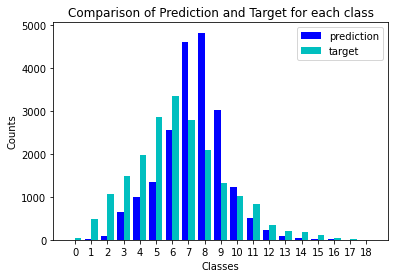

In [34]:
X_axis = np.arange(len(target))
plt.bar( X_axis - 0.2, pred.values(), width=0.4, color='b', align='center', label ='prediction')
plt.bar( X_axis + 0.2, target.values(), width=0.4, color='c', align='center', label = 'target')
plt.xticks(X_axis)
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.title("Comparison of Prediction and Target for each class")
plt.legend()
plt.show()